In [13]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import namedtuple, deque
from itertools import count
import pandas as pd
import numpy as np
import os
import skimage


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from alive_progress import alive_bar


from snake_game import SnakeGame

In [14]:
BATCH_SIZE = 128 # Is the number of transitions sampled from the replay buffer
gamma = 0.99 # Is the discount factor as mentioned in the previous section
eps_start = 0.9 # Is the starting value of epsilon
eps_end = 0.05 # Is the final value of epsilon
eps_decay = 1000 # Controls the rate of exponential decay of epsilon, higher means a slower decay
replay_memory = 10000
TAU = 0.005 # Is the update rate of the target network
learning_rate = 0.001 # learning rate of the ``AdamW`` optimizer
available_model = False
diff_actions = [-1,0,1]
n_actions = 3
EPISODES = 3000
MAX_STEPS_EPISODE = 1000

no_replay = False                               # Experience Replay flag
no_targetNetwork = False                         # Target Network flag



In [15]:
# 16x16 game with 1 pixel border = 14x14 game
w = 14
h = 14
b = 1
state = (h+2, w+2, 3) # Width, Height, Channels
game = SnakeGame(
    width=w,
    height=h,
    border = b,
    # food_amount = 1,
    # max_grass = 0.05, # recommendation
    # grass_growth = 0.001 # recommendation
)

In [16]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))



class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [17]:
class DQN(nn.Module):
    def __init__(self, observations, n_actions):
        super(DQN, self).__init__()
        n_observations = observations[0]*observations[1]*observations[2]
        #print(n_observations)
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [18]:
class DQN_Agent:
    def __init__(self,observations, actions, optimizer, gamma, epsilon):
        self.observations = observations
        self.actions = actions
        self.optimizer = optimizer
        self.criterion = nn.MSELoss()  
        self.replay = ReplayMemory(replay_memory)
        self.gamma = gamma
        self.max_epsilon = eps_start
        self.epsilon = epsilon
        self.min_epsilon = eps_end
        self.eps_decay = eps_decay
        #print('Observations:', self.observations)
        # print('Actions:', self.actions)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps")
        self._compile_model()
        
        
    def _compile_model(self):
        self.policy_net = DQN(self.observations, self.actions).to(self.device)
        self.target_net = DQN(self.observations, self.actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = self.optimizer(self.policy_net.parameters(), lr=learning_rate)
        
        
    def update_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

 
    def select_action(self, state, actions):
        random_nr = np.random.rand()
        
        if random_nr <= self.epsilon:
            return random.choice(actions)
        
        # Might be wrong
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor)
            return actions[torch.argmax(q_values).item()]
        
    def train(self, batch_size, actions, no_replay = False):
        
        if no_replay:
            batch = self.replay.sample(1)
        else:
            batch = random.sample(self.replay.memory, batch_size)

     
        current_states = torch.tensor([transition[0] for transition in batch], dtype=torch.float32).to(self.device)
        next_states = torch.tensor([transition[2] for transition in batch], dtype=torch.float32).to(self.device)
        #print("Shape of current state:", current_states.shape)
        #print("Shape of next state:", next_states.shape)
        current_qs_list = self.policy_net(current_states)
        future_qs_list = self.target_net(next_states)
        #print("Shape of current_qs_list:", current_qs_list.shape)
        #print("Shape of future_qs_list:", future_qs_list.shape)
        

        X = []
        Y = []
        for index in range(len(batch)):
            state, action, reward, next_state,done= batch[index]
            reward = reward[0, 0, 0]
            if done:
                max_future_q = reward
            else:
                #print('Gamma' + str(self.gamma))
                #print('Future qs list: {}'.format(future_qs_list[index]))
                #print('Max future q: {}'.format(torch.max(future_qs_list[index])))
                max_future_q = reward + self.gamma * torch.max(future_qs_list[index])

            current_qs = current_qs_list[index].clone()
            current_qs[actions.index(action)] = torch.tensor(max_future_q, dtype=torch.float32)
            X.append(state)
            Y.append(current_qs)
        
        X = np.array(X)
        X = torch.tensor(X, dtype=torch.float32).to(self.device)        

      

        # Zero the parameter gradients
        self.optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = self.policy_net(X)
        #print(Y)
        loss = self.criterion(outputs,torch.stack(Y))
    
        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    def update_epsilon(self, episode):
        #possibly flag the linear decay
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-1. * episode / self.eps_decay)

        

In [19]:
def best_action(game,actions):
    _,apple,head,tail,direction = game.get_state()
    
    X_head = head[0]
    y_head = head[1]
    
    if(direction == 0):
        possible_actions = [(y_head, X_head-1), (y_head-1, X_head), (y_head, X_head+1)]
    elif(direction == 1):
        possible_actions = [(y_head-1, X_head), (y_head, X_head+1), (y_head+1, X_head)]
    elif(direction == 2):
        possible_actions = [(y_head, X_head+1), (y_head+1, X_head), (y_head, X_head-1)]
    elif(direction == 3):
        possible_actions = [(y_head+1, X_head), (y_head, X_head-1), (y_head-1, X_head)]
        
    possible_distances = []
    #print('Apple: ' + str(apple[0]))
    #print('Actions: '+ str(possible_actions[0]))
    #print("test: " + str([math.dist(apple[0],possible_actions[0])]))
    
    for i in range(len(possible_actions)):
        if(not((possible_actions[i] in tail) or (possible_actions[i][0] < 0 or possible_actions[i][0] > w) or (possible_actions[i][1] < 0 or possible_actions[i][1] > h))):
            possible_distances.append([math.dist(apple[0],possible_actions[i]),actions[i]])
    
    if len(possible_distances) == 0:
        return np.random.choice(actions)
    
    min_distance = min(dist[0] for dist in possible_distances)
    minimums = []
    for j in possible_distances:
        if j[0] == min_distance:
            minimums.append(j[1])
    return np.random.choice(minimums)
    
def examples(agent, game, actions):
    steps_lower_limit = 100
    steps_upper_limit = 1000
    memory = 0
    max_memory = replay_memory
    
    steps_prev_lower_limit = np.random.randint(steps_lower_limit, steps_upper_limit)
    
    while memory < max_memory:
        game_flag = False
        state = game.reset()[0]
        i = 0
        while (not game_flag) and (steps_prev_lower_limit > i) and (memory < max_memory):
            action = best_action(game,actions)
            next_state, reward, game_flag, info = game.step(action)
            memory += 1
            agent.replay.push(state, action, next_state, reward,game_flag)
            state = next_state
            i += 1
            
    print(f"Replay Memory occupancy: {memory}")

In [20]:
def play_best_game(game, actions, n_games=5):
    fig,ax = plt.subplots()
    plt.axis('off')
    frames = []
    for g in range(n_games):
        state = game.reset()[0]
        game_flag = False
        i = 0
        while not game_flag and i < 100:
            frame = ax.imshow(state, animated=True)
            t = plt.annotate("game: " + str(g+1), (1,1))
            frames.append([frame,t])
            action = best_action(game,actions)
            next_state, _, game_flag, _ = game.step(action)
            state = next_state
            i += 1
    ani = animation.ArtistAnimation(fig, frames, interval=100)
    ani.save('best_game.gif')

### Plot training

In [21]:
def plot_train(game_stats, file):
    t_loss_mean = np.array(game_stats['training_loss']['mean'])
    t_loss_std  = np.array(game_stats['training_loss']['stds'])
    t_acc_mean  = np.array(game_stats['training_acc']['mean'])
    t_acc_std   = np.array(game_stats['training_acc']['stds'])
    apples      = np.array(game_stats['apples'])
    points      = np.array(game_stats['points'])
    print(t_loss_mean, t_loss_std, t_acc_mean, t_acc_std, apples, points)
    
    X = range(0, len(t_acc_mean))
    
    fig, ax = plt.subplots(4,figsize=(8,6))
    fig.tight_layout()
    ax[0].plot(t_acc_mean)
    ax[0].fill_between(X, t_acc_mean - t_acc_std, t_acc_mean + t_acc_std, alpha=0.2)
    
    ax[1].plot(t_loss_mean)
    ax[1].fill_between(X, t_loss_mean - t_loss_std, t_loss_mean + t_loss_std, alpha=0.2)
    ax[1].set_yscale('log')
    ax[1].set_title('Training Loss')
    
    ax[2].plot(apples)
    ax[2].set_title('Apples')
    
    ax[3].plot(points)
    ax[3].set_title('Points')
    
    plt.setp(ax[0], ylabel='Accuracy')
    plt.setp(ax[1], ylabel='Loss')
    plt.setp(ax[2], ylabel='Apples')
    plt.setp(ax[3], xlabel='Episodes', ylabel='Points')
    plt.savefig(file)
    plt.show()

In [22]:
agent = DQN_Agent(state, n_actions, optim.AdamW, gamma, eps_start)


In [23]:
def stack_image(queue):
    s_t = np.stack(queue, axis=2)
    return s_t

def grey_scale(image):
    x_t = skimage.color.rgb2gray(image)
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))
    return x_t

Replay Memory occupancy: 10000


on 0: /var/folders/x0/b0s4r41d0312h6mf4w2sqpfr0000gn/T/ipykernel_8730/2793855355.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
        current_qs[actions.index(action)] = torch.tensor(max_future_q, dtype=torch.float32)


on 9: □□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
on 9: Episode: 10
on 9: Total: 
       rewards: 97.03, apples: 106, steps: 120
on 9: Max: 
       rewards: 17.01, apples: 18, steps: 20
on 9: Chosen Epsilon: 0.89
on 9: □□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
on 19: □□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
on 19: Episode: 20
on 19: Total: 
        rewards: 188.10, apples: 206, steps: 237
on 19: Max: 
        rewards: 17.01, apples: 18, steps: 22
on 19: Chosen Epsilon: 0.88
on 19: □□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
on 29: □□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
on 29: Episode: 30
on 29: Total: 
        rewards: 282.11, apples: 310, steps: 354
on 29: Max: 
        rewards: 17.02, apples: 18, steps: 22
on 29: Chosen Epsilon: 0.88
on 29: □□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
on 39: □□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
on 39: Episode: 40
on 39: Total: 
        rewards: 385.17, apples: 423, steps: 484
on 39: Max: 
        rewards: 20.03, apples: 21, steps: 26
on 39: Chosen Epsilon: 0.87
on 39: □□□□□□□□□□□□□□

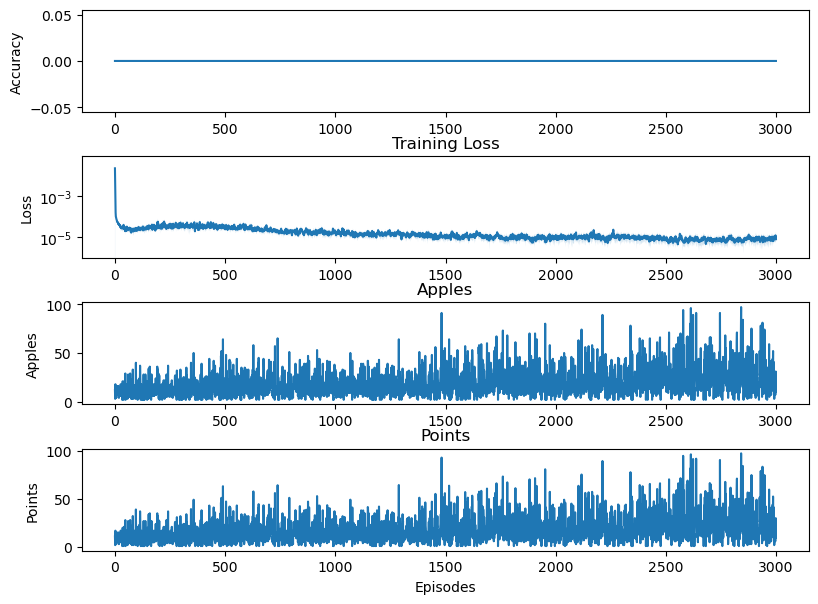

MovieWriter ffmpeg unavailable; using Pillow instead.


Model saved
Target Model saved


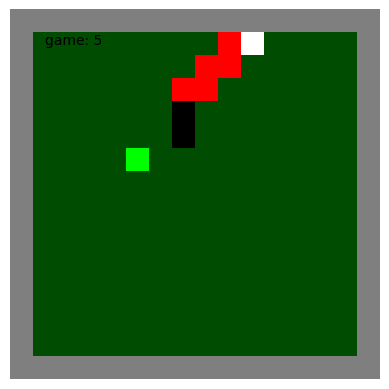

In [24]:
def run_episode(agent, game, diff_actions, max_steps):
    state = game.reset()[0]
    game_flag = False
    apples = 0
    steps = 0
    train_rewards = 0
    stats = []
    steps_to_upgrade=0

    while not game_flag and steps < max_steps:
        reshaped_state = state.reshape([1, state.shape[0], state.shape[1], state.shape[2]])
        steps += 1
        action = agent.select_action(reshaped_state, diff_actions)
        next_state, reward, game_flag, _ = game.step(action)

        # Experience Replay
        agent.replay.push(state, action, next_state, reward, game_flag)

        # Training
        if len(agent.replay) > BATCH_SIZE or no_replay:
            loss = agent.train(BATCH_SIZE, diff_actions, no_replay)
            stats.append((loss, 0))

        state = next_state

        if steps_to_upgrade >= 100:
            agent.update_model()
            steps_to_upgrade = 0

        if reward >= 1:
            apples += 1

        train_rewards += reward

    return train_rewards, apples, steps, stats

def update_game_stats(game_stats, stats, apples, train_rewards):
    game_stats['apples'].append(apples)
    game_stats['points'].append(train_rewards)

def display_episode_info(curr_episode, total_reward, total_apples, total_steps, max_reward, max_apples, max_steps):
    print("□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□")
    print("Episode: {}".format(curr_episode))
    print('Total: \n rewards: {:.2f}, apples: {}, steps: {}'.format(total_reward, total_apples, total_steps))
    print('Max: \n rewards: {:.2f}, apples: {}, steps: {}'.format(max_reward, max_apples, max_steps))
    print('Chosen Epsilon: {:.2f}'.format(agent.epsilon))
    print("□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□")


def main():
    curr_episode = 0
    total_reward = 0
    max_reward = -1
    total_apples = 0
    max_apples = 0
    total_steps = 0
    max_steps = 0

    examples(agent, game, diff_actions)
    game_stats = {
                  'apples': [],
                  'points': []}

    with alive_bar(EPISODES) as bar:
        for episode in range(EPISODES):
            curr_episode = episode + 1
            train_rewards, apples, steps, e_stats = run_episode(agent, game, diff_actions, MAX_STEPS_EPISODE)

            if max_reward < train_rewards:
                max_reward = train_rewards
            if max_apples < apples:
                max_apples = apples
            if max_steps < steps:
                max_steps = steps
            total_reward += train_rewards
            total_apples += apples
            total_steps += steps

            if curr_episode % 10 == 0:
                display_episode_info(curr_episode, total_reward, total_apples, total_steps, max_reward, max_apples, max_steps)

            update_game_stats(game_stats, e_stats, apples, train_rewards)
            agent.update_epsilon(curr_episode)
            bar()

    plot_train(game_stats, 'game_stats.png')
    torch.save(agent.policy_net.state_dict(), 'model.pth')
    print("Model saved")

    #save target network
    torch.save(agent.target_net.state_dict(), 'target_model.pth')
    print("Target Model saved")
    
    
main()
play_best_game(game, diff_actions, 5)